## Задание 1

[kaggle task](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

Есть датасет с характеристиками покупателей в магазине.
<br>
Требуется разбить покупателей на k кластеров (выбор k остается за тобой), посчитать силуэт и визуализировать полученные кластеры

Выбор k должен быть обоснован, применять можно абсолютно любые алгоритмы.

**Заметка**: можно генерировать новые признаки и/или не использовать все имеющиеся, да и вообще делать все, что угодно и не противоречит здравому смыслу :)

**Не забывай фиксировать random_state для воспроизводимости результатов, где это требуется**

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score

from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform

import seaborn as sns

In [2]:
SEED = 42

In [3]:
df = pd.read_csv('data/mall_customers.csv')
print(df.shape)
df.head()

(200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
#бинаризуем Gender
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

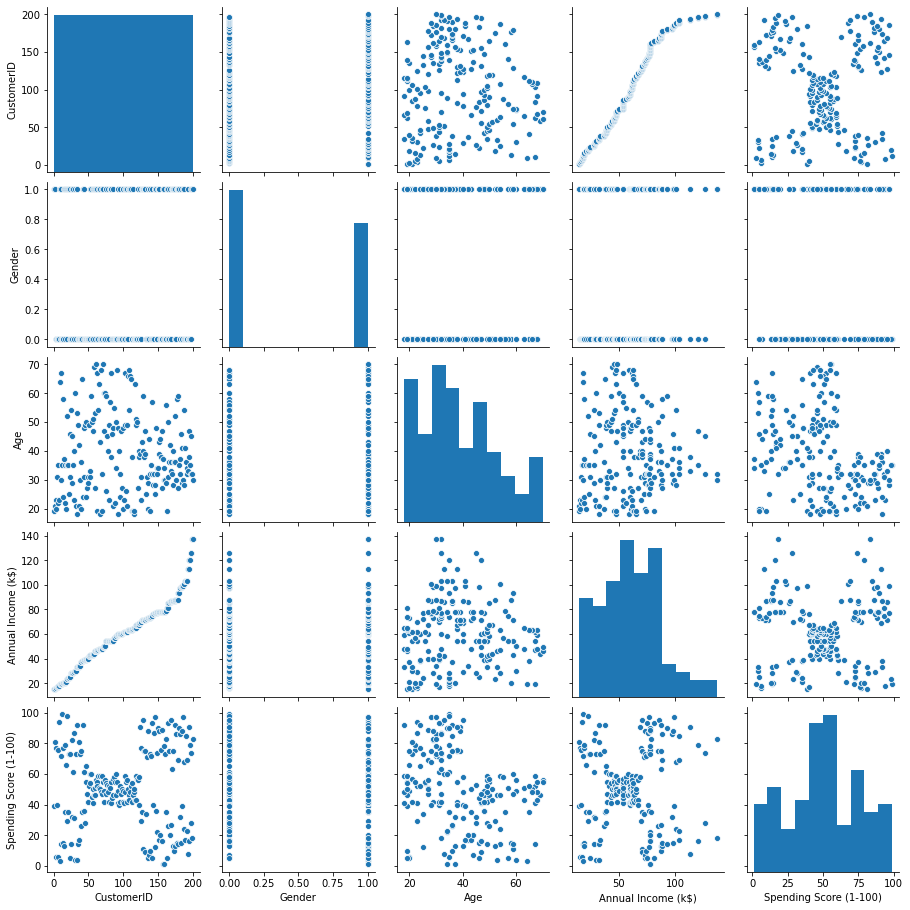

In [6]:
sns.pairplot(df)

На график пары признаков СustomerID и Spending Score выделяется хорошо 5 кластеров, на паре Annual Income и Spending Score тоже 5, скорее в силу того что СustomerID растер одновременно с Annual Income. Признак CustomerID по этой причине можно не использовать.

In [7]:
X = df.drop('CustomerID', axis = 1).copy()

In [8]:
X.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


In [9]:
def hopkins_statistics(X):
    '''Calculate hopkins statistics to check cluster stucture in data
    
    Parameters:
        X - numpy matrix
        
    Return:
        statistics
        
    Note:
        Estimation the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
        no clusterability and a score tending to 0 express a high cluster tendency
    '''
    n, d = X.shape[0], X.shape[1]
    m = int(0.1 * n) # heuristic from article
    
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
 
    rand_X = sample(range(n), m)
 
    ujd = []
    wjd = []
    for j in range(m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0), np.amax(X,axis=0), d).reshape(1, -1)
                                    , 2, return_distance=True)
        ujd.append(u_dist[0][1])
        
        w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(wjd) / (sum(ujd) + sum(wjd))
    
    return H

In [10]:
print(f'Hopkins statistics: {hopkins_statistics(np.array(X))}')

Hopkins statistics: 0.2659617105037722


### Kmeans

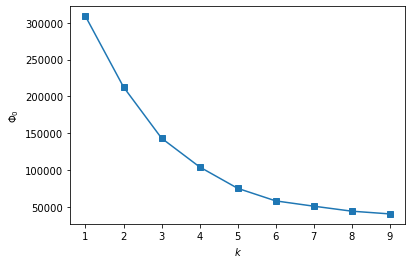

In [11]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$\Phi_0$');

График инерции подтверждает наши догадки, начиная с $k=5$ "падение" кривой перестает быть резким, следовательно, оптимально, выбрать $k = 5$

In [12]:
kmeans = KMeans(n_clusters = 5,  random_state = SEED).fit(X)

yhat_kmeans = kmeans.predict(X)

colors = ['c' if x==0 else 'b' if x==1 else 'g' if x==2 else 'black'  if x==3  else 'y' if x==4 else 'h'
              for x in yhat_kmeans]

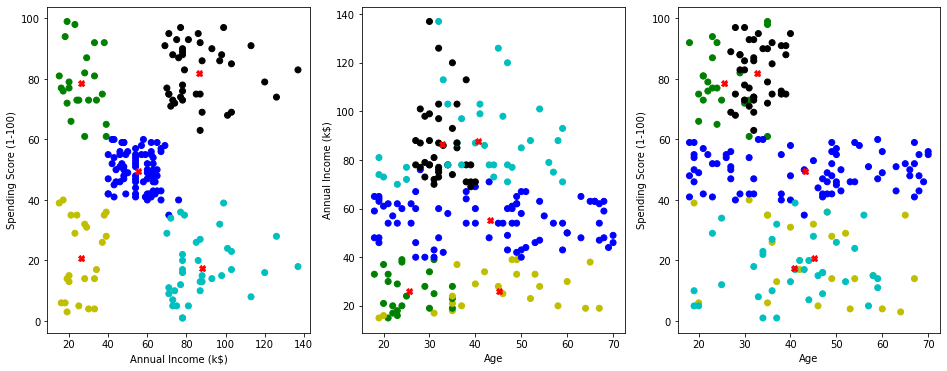

In [13]:
plt.figure(figsize=(16, 6))
features = X.columns.values
comb = [(2,3), (1,2),(1,3)]
for k in range(3):
    i,j = comb[k]
    plt.subplot(1, 3, k + 1)
    for q in range(kmeans.cluster_centers_.shape[0]):
        plt.plot(kmeans.cluster_centers_[q, i], kmeans.cluster_centers_[q, j], 'rX')
    plt.scatter(X[features[i]], X[features[j]], c=colors, picker=True)
    plt.xlabel(features[i])
    plt.ylabel(features[j])

In [14]:
print(f'Silhouette score K-means: {silhouette_score(X, yhat_kmeans)}')

Silhouette score K-means: 0.4440669204743008


### Агломеративная иерархичекая кластеризация

In [15]:
from scipy.cluster.hierarchy import dendrogram

In [16]:
def plot_dendrogram(model, **kwargs):
    '''Create linkage matrix and then plot the dendrogram
    create the counts of samples under each node
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [17]:
agclust = AgglomerativeClustering(n_clusters=None, distance_threshold=1).fit(X)
yhat_agclust = agclust.labels_

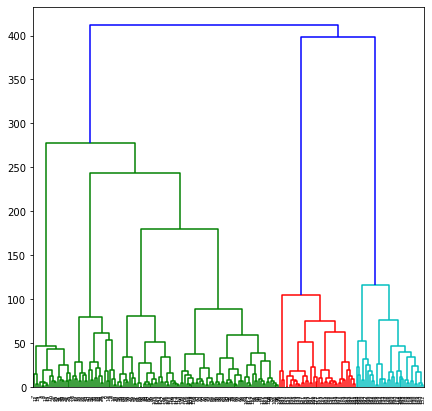

In [18]:
plt.figure(figsize=(7, 7))
plot_dendrogram(agclust)

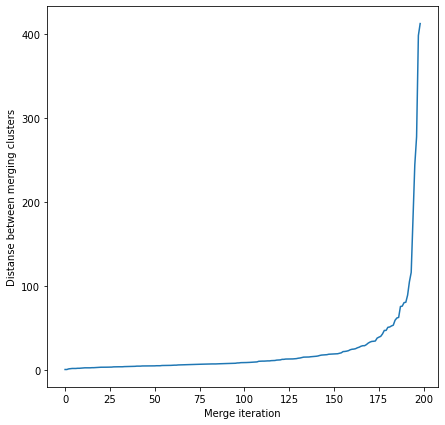

In [19]:
plt.figure(figsize=(7,7))
plt.ylabel('Distanse between merging clusters')
plt.xlabel('Merge iteration')
plt.plot(list(range(len(agclust.distances_))), agclust.distances_)

Рост начинается в промежутке 175-190, что как раз соответствует 5 кластерам.

In [20]:
agclust = AgglomerativeClustering(n_clusters = 5).fit(X)
yhat_agclust = agclust.labels_

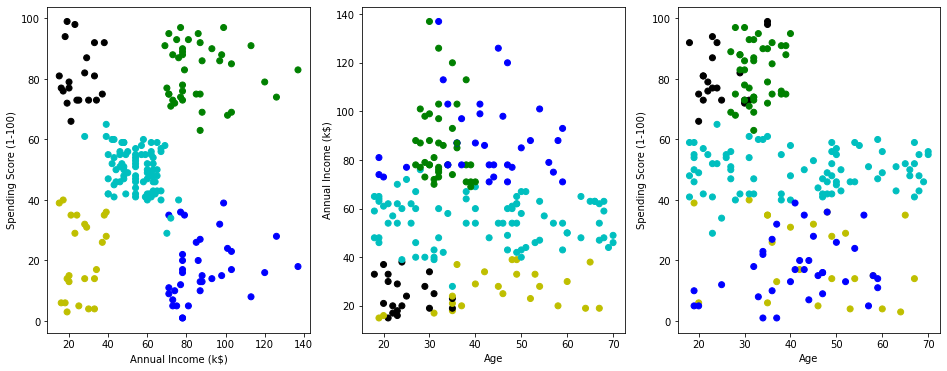

In [21]:
colors = ['c' if x==0 else 'b' if x==1 else 'g' if x==2 else 'black'  if x==3  else 'y' if x==4 else 'h'
              for x in yhat_agclust]

plt.figure(figsize=(16, 6))
features = X.columns.values
comb = [(2,3), (1,2),(1,3)]
for k in range(3):
    i,j = comb[k]
    plt.subplot(1, 3, k + 1)
    plt.scatter(X[features[i]], X[features[j]], c=colors, picker=True)
    plt.xlabel(features[i])
    plt.ylabel(features[j])

In [22]:
print(f'Silhouette score agglomerative clustering: {silhouette_score(X, yhat_agclust)}')

Silhouette score agglomerative clustering: 0.43997527212476695


### DBSCAN

In [23]:
dbscan = DBSCAN(eps = 20, min_samples = 20).fit(X)
yhat_dbscan = dbscan.labels_
print(yhat_dbscan)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1  0  0 -1  0
 -1 -1  0  0  0 -1 -1  0 -1 -1 -1  0 -1  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0
 -1 -1 -1 -1 -1 -1 -1 -1]


In [24]:
print(f'Silhouette score DBSCAN: {silhouette_score(X, yhat_dbscan)}')

Silhouette score DBSCAN: 0.2527697357495434


## Задание 2 (по желанию)

Возьмем стандартный датасет ирисов, состоящий из 4-х признаков длины/ширины внутренней и наружной долей околоцветника и таргета - вид цветка (kind).

1.Требуется кластеризовать цветки (да-да, количество кластеров уже известно), посчитать **accuracy**. Выбор алгоритма опять же на усмотрение (может быть несколько)
<br>
**Важно**: метки могут расставиться в другом порядке относительно истинного таргета, то есть после кластеризации будут получены 0, а это на самом деле 1, то есть надо сделать отображение $0 \rightarrow 1$ , то же самое касается и других меток. 
<br>
Поэтому, получив метки кластеров, стоит перебрать все возможные их перестановки. В этом поможет itertools.permutations

2.Воспользоваться любым/любыми пройденными/известными алгоритмами классификации и посчитать **accuracy** 
<br>
(Например, логистической регрессией)

In [25]:
from sklearn import datasets
import itertools

##other libraries on need##

In [26]:
df = datasets.load_iris()
df = pd.DataFrame(np.hstack([df['data'], df['target'].reshape(-1,1)])
             , columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'kind'])

print('Count of unique flowers', df['kind'].unique().shape[0])
df.head()

Count of unique flowers 3


,sepal_length,sepal_width,petal_length,petal_width,kind
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Кластеризация

In [27]:
def validate_with_mappings(y_true, y_pred):
    '''
    Check all possible permutations to maximize accuracy
    '''
    
    l = []
    permutations = itertools.permutations([0, 1, 2])
    for a, b, c in permutations:
        mapping = {0 : a, 1: b, 2: c}
        mapped_preds = [mapping[pred] for pred in y_pred]
        l.append((mapping, sum(mapped_preds == y_true) / len(y_true)))
                 
    return l

In [28]:
X = df.iloc[:, :-1]
y = df['kind']

#### Kmeans

In [29]:
kmeans = KMeans(n_clusters = 3,  random_state = SEED).fit(X)
y_pred_kmeans = kmeans.predict(X)

a = validate_with_mappings(y, y_pred_kmeans)

print(max([x[1] for x in a]))

0.8933333333333333


In [30]:
colors = ['r' if x==0 else 'b' if x==1 else 'g' 
              for x in y_pred_kmeans]

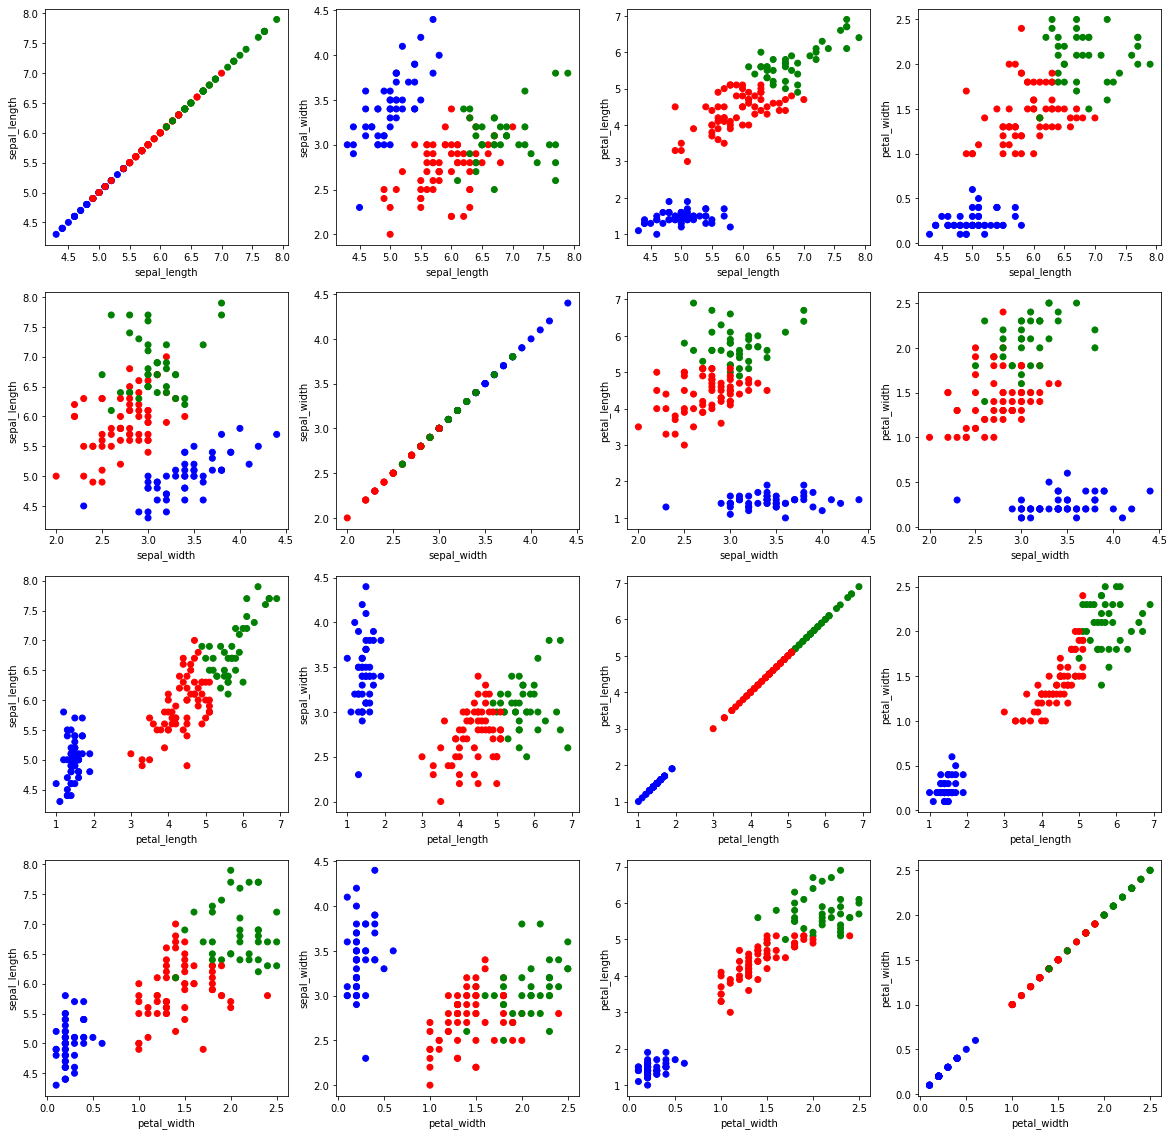

In [31]:
plt.figure(figsize=(20, 20))
features = X.columns.values

for i in range(4):
    for j in range(4):   
        plt.subplot(4,4, i*4+j+1)
        plt.scatter(X[features[i]], X[features[j]], c=colors, picker=True)
        plt.xlabel(features[i])
        plt.ylabel(features[j])

#### Агломеративная иерархичекая кластеризация

In [32]:
agclust = AgglomerativeClustering(n_clusters = 3).fit(X)
y_pred_agclust = agclust.labels_

a = validate_with_mappings(y, y_pred_agclust)

print(round(max([x[1] for x in a]),3))

0.893


In [33]:
colors = ['r' if x==0 else 'b' if x==1 else 'g' 
              for x in y_pred_agclust]

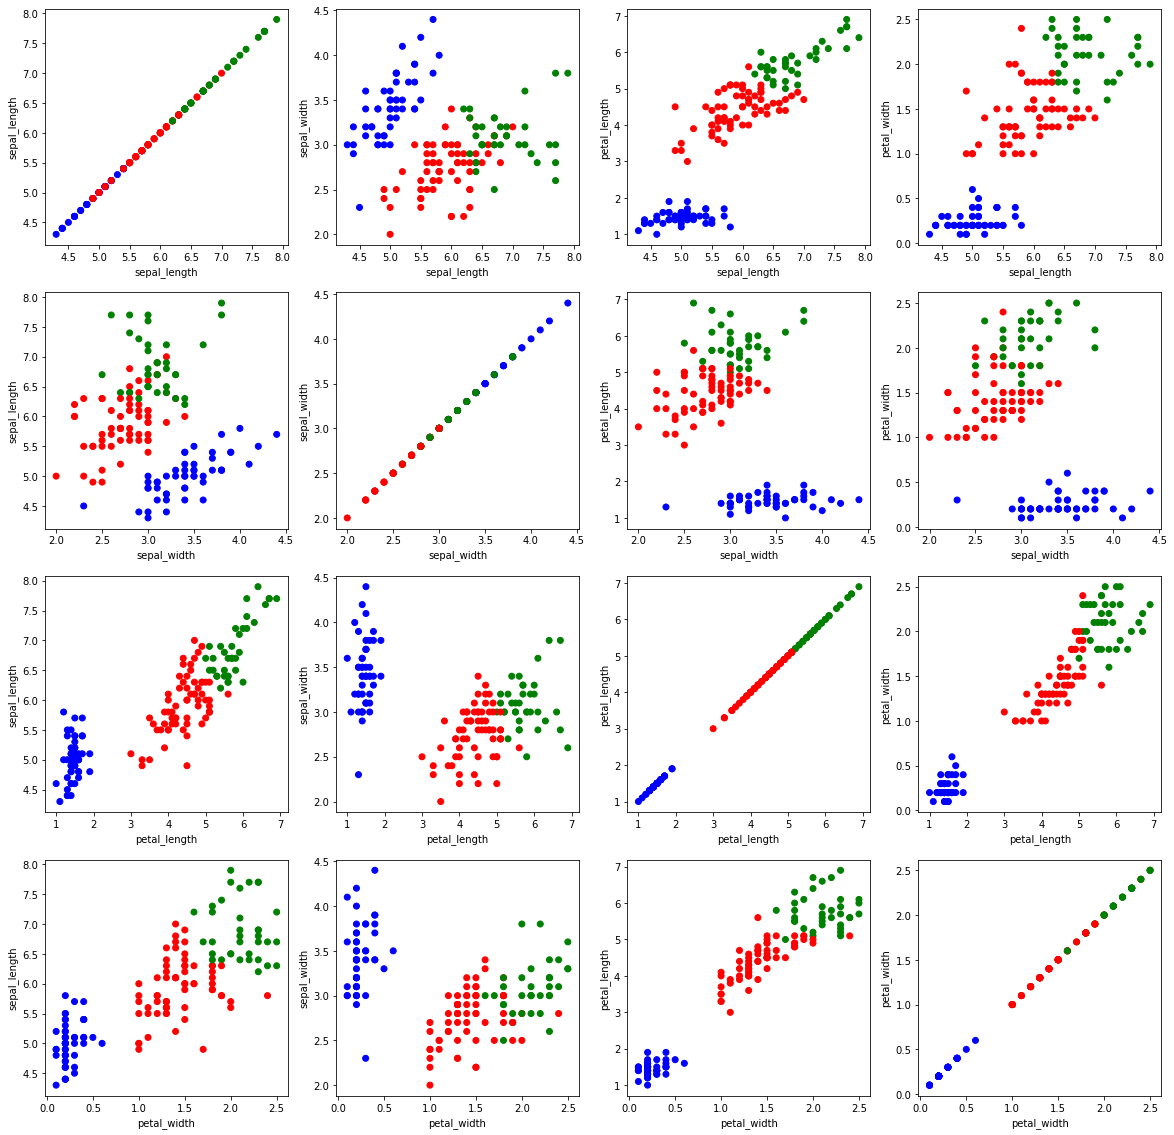

In [34]:
plt.figure(figsize=(20, 20))
features = X.columns.values

for i in range(4):
    for j in range(4):   
        plt.subplot(4,4, i*4+j+1)
        plt.scatter(X[features[i]], X[features[j]], c=colors, picker=True)
        plt.xlabel(features[i])
        plt.ylabel(features[j])

### Классификация

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

clf = LogisticRegression(solver = 'liblinear')

cv = ShuffleSplit(n_splits = 5, test_size=0.3, random_state = SEED)
scores = cross_val_score(clf, X, y, cv = cv, scoring='accuracy')
print(scores)
print('Среднее значение accuracy на кросс-валидации', round(scores.mean(),3))

[0.97777778 0.95555556 0.86666667 0.97777778 0.91111111]
Среднее значение accuracy на кросс-валидации 0.938


**Вопрос**: что оказалось лучше: алгоритм классификации или кластеризации и на сколько?
<br>
**Ответ**: алгоритм классификации в среднем на 0.04 по метрике